# Regression Project (Store Sales -- Time Series Forecasting)

**GOAL:** 
The goal of this analysis is to build a Model that predicts the sales for product families sold at Favorita stores located in Ecuador

**HYPOTHESIS**

* Promotion impacts the number of sales and transactions positively
* Highest sales of the year occurs on December

**QUESTIONS**
1. Is the train dataset complete (has all the required dates)?
2. Are sales influenced by specific dates in the year?
3. Which month has the highest sales record?
4. Top 10 Stores based on total sales, and total transactions
5. What is the Sales Trend for each Family?
6. What is the Sales Trend for each Store Number?
7. What is the trend in transactions for each store number?
8. Are certain groups of stores selling more products? (Cluster, city, state, type)
9. Did the earthquake that struck Ecuador on April 16, 2016 impact sales?
10. Are sales affected by promotions? 

## Importing the required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error as msle
from statsmodels.graphics import tsaplots
import lightgbm as lgb
from sklearn.datasets import load_iris
import os, pickle
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset from Data Folder

In [2]:
train= pd.read_csv('Data/train.csv', index_col='id')
test_df= pd.read_csv('Data/test.csv')
transactions= pd.read_csv('Data/transactions.csv')
stores= pd.read_csv('Data/stores.csv')
holidays_event= pd.read_csv('Data/holidays_events.csv')
oil= pd.read_csv('Data/oil.csv')
sample_submission= pd.read_csv('Data/sample_submission.csv')

## Dataset Exploration

Let's check the content of each data file, columns information and percentage of missing values in them

In [3]:
# Visualizing train data
train.head(10)

date  store_nbr        family  sales  onpromotion
id                                                         
0   2013-01-01          1    AUTOMOTIVE    0.0            0
1   2013-01-01          1     BABY CARE    0.0            0
2   2013-01-01          1        BEAUTY    0.0            0
3   2013-01-01          1     BEVERAGES    0.0            0
4   2013-01-01          1         BOOKS    0.0            0
5   2013-01-01          1  BREAD/BAKERY    0.0            0
6   2013-01-01          1   CELEBRATION    0.0            0
7   2013-01-01          1      CLEANING    0.0            0
8   2013-01-01          1         DAIRY    0.0            0
9   2013-01-01          1          DELI    0.0            0

In [4]:
# Visualizing test data
test_df.head(10)

id        date  store_nbr        family  onpromotion
0  3000888  2017-08-16          1    AUTOMOTIVE            0
1  3000889  2017-08-16          1     BABY CARE            0
2  3000890  2017-08-16          1        BEAUTY            2
3  3000891  2017-08-16          1     BEVERAGES           20
4  3000892  2017-08-16          1         BOOKS            0
5  3000893  2017-08-16          1  BREAD/BAKERY           12
6  3000894  2017-08-16          1   CELEBRATION            0
7  3000895  2017-08-16          1      CLEANING           25
8  3000896  2017-08-16          1         DAIRY           45
9  3000897  2017-08-16          1          DELI           18

In [5]:
# Visualizing transaction data
transactions.head(10)

date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922
5  2013-01-02          5          1903
6  2013-01-02          6          2143
7  2013-01-02          7          1874
8  2013-01-02          8          3250
9  2013-01-02          9          2940

In [6]:
# Visualizing stores data
stores.head(10)

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4
5          6          Quito                       Pichincha    D       13
6          7          Quito                       Pichincha    D        8
7          8          Quito                       Pichincha    D        8
8          9          Quito                       Pichincha    B        6
9         10          Quito                       Pichincha    C       15

In [7]:
# Visualizing holidays_event data
holidays_event.head(10)

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   
5  2012-05-12  Holiday     Local        Puyo         Cantonizacion del Puyo   
6  2012-06-23  Holiday     Local    Guaranda      Cantonizacion de Guaranda   
7  2012-06-25  Holiday  Regional    Imbabura  Provincializacion de Imbabura   
8  2012-06-25  Holiday     Local   Latacunga     Cantonizacion de Latacunga   
9  2012-06-25  Holiday     Local     Machala           Fundacion de Machala   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  
5        False  
6        False  
7        False  
8        False  
9        False

In [8]:
# Visualizing oil data
oil.head(10)

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20
5  2013-01-08       93.21
6  2013-01-09       93.08
7  2013-01-10       93.81
8  2013-01-11       93.60
9  2013-01-14       94.27

In [9]:
# Visualizing sample_submission data
sample_submission.head()

id  sales
0  3000888    0.0
1  3000889    0.0
2  3000890    0.0
3  3000891    0.0
4  3000892    0.0

### Renaming Identical column names

In [10]:
stores.rename(columns={'type':'store_type'}, inplace=True) # Renaming 'type' column in stores
holidays_event.rename(columns={'type':'holiday_type'}, inplace=True) # Renaming 'type' column in holidays_event

## Missing data Analysis

In [11]:
# Putting all datasets into one dictionary. This will be helpful in seeking missing data
Datasets = {'train':train,'test_df':test_df,'transactions':transactions, 'oil':oil,
            'holidays_event':holidays_event,
            'stores':stores,'sample_submission':sample_submission}

In [12]:
# Checking the number of missing values in all dataaset
""" We are going to use this simple functions; [.isnull()] and [.sum()]."""
for data in Datasets: 
    print('-'*25)
    print(data)
    print('-'*25)
    print(Datasets[data].isnull().sum())
    print()

-------------------------
train
-------------------------
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

-------------------------
test_df
-------------------------
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

-------------------------
transactions
-------------------------
date            0
store_nbr       0
transactions    0
dtype: int64

-------------------------
oil
-------------------------
date           0
dcoilwtico    43
dtype: int64

-------------------------
holidays_event
-------------------------
date            0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dtype: int64

-------------------------
stores
-------------------------
store_nbr     0
city          0
state         0
store_type    0
cluster       0
dtype: int64

-------------------------
sample_submission
-------------------------
id       0
sales    0
dtype: int64


## Fixing missing data

* We can observe that only the 'oil' dataset has missing values in them (43 null values in [dcoilwtico] column)
* So we will visualise the missing values to see what method we can use to fill the missing values since there is no way to get the actual values

<AxesSubplot:>

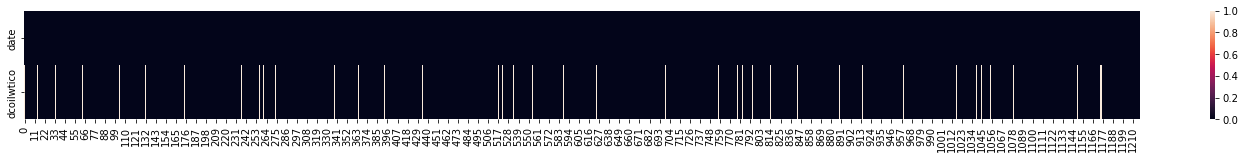

In [13]:
# Visualizing missing values with heatmap plot
fig, ax = plt.subplots(figsize=(25,2)) 
sns.heatmap(oil.isna().transpose())

In [14]:
# Checking the indexes with missing values
oil[oil['dcoilwtico'].isnull()].index

Int64Index([   0,   14,   34,   63,  104,  132,  174,  237,  256,  261,  274,
             294,  338,  364,  393,  434,  497,  517,  522,  534,  554,  588,
             624,  653,  699,  757,  778,  783,  794,  814,  843,  889,  914,
             959, 1017, 1039, 1044, 1054, 1079, 1118, 1149, 1174, 1175],
           dtype='int64')

In [15]:
# Let's fill in these missing values using [backfill] method.
"""This will replace the missing values with values in the rows next to them"""
oil = oil.fillna(method = 'backfill')
oil.iloc[[0,1,14,15],:]

date  dcoilwtico
0   2013-01-01       93.14
1   2013-01-02       93.14
14  2013-01-21       96.09
15  2013-01-22       96.09

In [16]:
# Converting date column in oil data to datetime object
oil['date'] = pd.to_datetime(oil['date'])

Text(0.5, 1.0, 'Oil price')

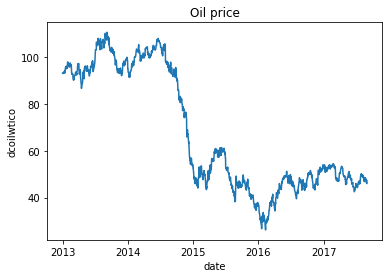

In [17]:
# Plotting trends in oil prices
sns.lineplot(data=oil, x = 'date', y = 'dcoilwtico')
plt.title('Oil price')

## Q1. Is the train dataset complete (has all the required dates)?

To check if the dates are complete, we will:
* Convert date column to datetime object
* Check the range of dates in the data
* Check the 'expected' number of days from the range
* Check the the 'actual' number of days in the data
* Compare the expected number of days from the dates range with the actual number of days in the data
* If there are differnce between the actual days and expected days, we find the missing dates and replace them

In [18]:
# Converting date column to datetime object
train['date']=pd.to_datetime(train['date']).dt.date

In [19]:
# Checking the range of date
train.date.min(), train.date.max()

(datetime.date(2013, 1, 1), datetime.date(2017, 8, 15))

In [20]:
# Checking expected number of days from the dates range by subtracting min date from max date
difference= (train['date'].max()- train['date'].min())
difference

datetime.timedelta(days=1687)

In [21]:
# Since we subtracted min date from maxdate, we need to add 1 day to get a complete number of days(expected days)
difference.days + 1

1688

In [22]:
# Checking the Atual number of days in data
train['date'].nunique()

1684

We have differences in the expected number of days and actual number of days. Which means that there are some missing dates. To find the missing dates:

 * We will create a variable for the list of expected dates
 * We find the difference between the sets of the expected dates and actual dates, which will be our missing dates

In [23]:
# Creating a variable for expected dates
expected_days = (pd.date_range(start=train['date'].min(), end=train['date'].max())).date
expected_days

array([datetime.date(2013, 1, 1), datetime.date(2013, 1, 2),
       datetime.date(2013, 1, 3), ..., datetime.date(2017, 8, 13),
       datetime.date(2017, 8, 14), datetime.date(2017, 8, 15)],
      dtype=object)

In [24]:
# finding the difference between the sets of the expected dates and actual dates (missing dates)
set(expected_days)- set(train['date'])

{datetime.date(2013, 12, 25),
 datetime.date(2014, 12, 25),
 datetime.date(2015, 12, 25),
 datetime.date(2016, 12, 25)}

Now we can see that the 4 missing dates are all from 25th December of each year, which is probably a holiday. But since this is a time series forcasting, we will;
* Fill in the missing dates for all stores and item families 
* Fill  sales and onpromotion column with '0'

In [25]:
from itertools import product

In [26]:

train.head(5)

date  store_nbr      family  sales  onpromotion
id                                                       
0   2013-01-01          1  AUTOMOTIVE    0.0            0
1   2013-01-01          1   BABY CARE    0.0            0
2   2013-01-01          1      BEAUTY    0.0            0
3   2013-01-01          1   BEVERAGES    0.0            0
4   2013-01-01          1       BOOKS    0.0            0

In [27]:
# Defining variables for missing dates,  unique values in the store_nbr, and onpromotion columns
missing_dates = set(expected_days)- set(train['date'])
unique_stores = train.store_nbr.unique()
unique_families = train.family.unique()

In [28]:
""" To replace missing dates in the train data, we have
to do that for all the unique [store_nbr], and unique [Family].
So we will use product function from itertools to pair all the 4 missing
dates with the 54 unique stores and 33 unique family or item categories"""

missing_data = list(product(missing_dates, unique_stores, unique_families))


In [29]:
# Converting our missing data into pandas DataFrame
add_data = pd.DataFrame(missing_data, columns= ['date', 'store_nbr', 'family'], )
add_data

date  store_nbr                      family
0     2016-12-25          1                  AUTOMOTIVE
1     2016-12-25          1                   BABY CARE
2     2016-12-25          1                      BEAUTY
3     2016-12-25          1                   BEVERAGES
4     2016-12-25          1                       BOOKS
...          ...        ...                         ...
7123  2013-12-25          9                     POULTRY
7124  2013-12-25          9              PREPARED FOODS
7125  2013-12-25          9                     PRODUCE
7126  2013-12-25          9  SCHOOL AND OFFICE SUPPLIES
7127  2013-12-25          9                     SEAFOOD

[7128 rows x 3 columns]

In [30]:
# Adding our missing data to our train data to get a complete train data with all dates
train_data = pd.concat([train, add_data], ignore_index = True)
train_data

date  store_nbr                      family  sales  onpromotion
0        2013-01-01          1                  AUTOMOTIVE    0.0          0.0
1        2013-01-01          1                   BABY CARE    0.0          0.0
2        2013-01-01          1                      BEAUTY    0.0          0.0
3        2013-01-01          1                   BEVERAGES    0.0          0.0
4        2013-01-01          1                       BOOKS    0.0          0.0
...             ...        ...                         ...    ...          ...
3008011  2013-12-25          9                     POULTRY    NaN          NaN
3008012  2013-12-25          9              PREPARED FOODS    NaN          NaN
3008013  2013-12-25          9                     PRODUCE    NaN          NaN
3008014  2013-12-25          9  SCHOOL AND OFFICE SUPPLIES    NaN          NaN
3008015  2013-12-25          9                     SEAFOOD    NaN          NaN

[3008016 rows x 5 columns]

In [31]:
# Filling NaN values in our sales and onpromotion column (from add_data) with '0'
train_data.fillna(0,inplace=True)
train_data

date  store_nbr                      family  sales  onpromotion
0        2013-01-01          1                  AUTOMOTIVE    0.0          0.0
1        2013-01-01          1                   BABY CARE    0.0          0.0
2        2013-01-01          1                      BEAUTY    0.0          0.0
3        2013-01-01          1                   BEVERAGES    0.0          0.0
4        2013-01-01          1                       BOOKS    0.0          0.0
...             ...        ...                         ...    ...          ...
3008011  2013-12-25          9                     POULTRY    0.0          0.0
3008012  2013-12-25          9              PREPARED FOODS    0.0          0.0
3008013  2013-12-25          9                     PRODUCE    0.0          0.0
3008014  2013-12-25          9  SCHOOL AND OFFICE SUPPLIES    0.0          0.0
3008015  2013-12-25          9                     SEAFOOD    0.0          0.0

[3008016 rows x 5 columns]

## Q.2 Are sales influenced by specific dates in the year?

To know if sales are influenced by specific dates in the year, we will identify the dates where peak sales occured in each year and check if there are some relationships or inferences to make from it. We will follow the following process:
* Aggregate sales for each particular date
* Plot aggregated sales to visuaalise sales trend for each year
* Extract and add a [year] column to aggregated_sales_per_date
* Group [year] by [sales] to know the maximum sales for each year
* Extract the dates that maximum sales occured for each year
* Extract the dates that minimum sales occured for each year

In [32]:
# Aggregate sales for each particular date
aggregated_sales_per_date = train.groupby(['date'], as_index = False)['sales'].sum()
aggregated_sales_per_date.head()

date          sales
0  2013-01-01    2511.618999
1  2013-01-02  496092.417944
2  2013-01-03  361461.231124
3  2013-01-04  354459.677093
4  2013-01-05  477350.121229

<AxesSubplot:xlabel='date'>

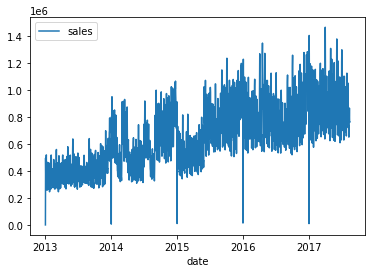

In [33]:
# Plotting aggregated sales to visuaalise sales trend for each year
aggregated_sales_per_date.plot(x= 'date', y= 'sales', kind= 'line')

In [34]:
# Extracting the year for each sales date to a new column [year]
train_data['year']= pd.to_datetime(train_data['date']).dt.year

In [35]:
# Visualising the new column [year]
train_data.head()

date  store_nbr      family  sales  onpromotion  year
0  2013-01-01          1  AUTOMOTIVE    0.0          0.0  2013
1  2013-01-01          1   BABY CARE    0.0          0.0  2013
2  2013-01-01          1      BEAUTY    0.0          0.0  2013
3  2013-01-01          1   BEVERAGES    0.0          0.0  2013
4  2013-01-01          1       BOOKS    0.0          0.0  2013

In [36]:
# Extracting and adding a [year] column to aggregated_sales_per_date

""" This will help us in grouping [year] by [sales] to know the maximum sales
for eaach year so that we can extract the dates the maximum sales occured for each year"""

aggregated_sales_per_date['year']= pd.to_datetime(aggregated_sales_per_date['date']).dt.year
aggregated_sales_per_date.head()

date          sales  year
0  2013-01-01    2511.618999  2013
1  2013-01-02  496092.417944  2013
2  2013-01-03  361461.231124  2013
3  2013-01-04  354459.677093  2013
4  2013-01-05  477350.121229  2013

In [37]:
# Grouping [year] by [sales] to know the maximum sales for each year
aggregated_sales_per_date.groupby(['year'], as_index = False)['sales'].max()

year         sales
0  2013  7.928653e+05
1  2014  1.064978e+06
2  2015  1.234131e+06
3  2016  1.345921e+06
4  2017  1.463084e+06

In [38]:
# Extracting the dates that maximum sales occured for each year
tmp = aggregated_sales_per_date.groupby(['year'], as_index = False)['sales'].max()
for row in tmp.itertuples():
    musk = (aggregated_sales_per_date['year'] == row.year) & (aggregated_sales_per_date['sales'] == row.sales)
    tmp_row = aggregated_sales_per_date.loc[musk]
    print('peak sales for', row.year, 'occured on', tmp_row['date'].values, 'for', row.sales, 'items')

peak sales for 2013 occured on [datetime.date(2013, 12, 23)] for 792865.284427 items
peak sales for 2014 occured on [datetime.date(2014, 12, 23)] for 1064977.9730725 items
peak sales for 2015 occured on [datetime.date(2015, 10, 4)] for 1234130.938595 items
peak sales for 2016 occured on [datetime.date(2016, 4, 18)] for 1345920.6048929 items
peak sales for 2017 occured on [datetime.date(2017, 4, 1)] for 1463083.962459 items


In [39]:
# Extracting the dates that minimum sales occured for each year
tmp = aggregated_sales_per_date.groupby(['year'], as_index = False)['sales'].min()
for row in tmp.itertuples():
    musk = (aggregated_sales_per_date['year'] == row.year) & (aggregated_sales_per_date['sales'] == row.sales)
    tmp_row = aggregated_sales_per_date.loc[musk]
    print('Minimum sales for', row.year, 'occured on', tmp_row['date'].values, 'for', row.sales, 'items')

Minimum sales for 2013 occured on [datetime.date(2013, 1, 1)] for 2511.618999 items
Minimum sales for 2014 occured on [datetime.date(2014, 1, 1)] for 8602.065404 items
Minimum sales for 2015 occured on [datetime.date(2015, 1, 1)] for 12773.61698 items
Minimum sales for 2016 occured on [datetime.date(2016, 1, 1)] for 16433.394 items
Minimum sales for 2017 occured on [datetime.date(2017, 1, 1)] for 12082.500997 items


## Q.3 Which month has the highest sales record?

To get the month with the highest sales record from 2013 to 2017, we will:
* Extract the month from [date] column to form a new column [month]
* Group total sales for each month and sort in descending order
* Plot a graph to Visualise total saales by months

In [40]:
# Extract the month from [date] column to form a new column [month]
train_data['month']= pd.to_datetime(train_data['date']).dt.month

In [41]:
# Group total sales for each month and sort in descending order
sales_per_month= train_data.groupby(['month'], as_index = False)['sales'].sum(
        ).sort_values(by= 'sales', ascending = False).reset_index(drop=True)
sales_per_month

month         sales
0       7  1.033631e+08
1       3  9.722849e+07
2      12  9.702784e+07
3       6  9.451670e+07
4       1  9.444215e+07
5       5  9.439914e+07
6       4  9.066812e+07
7       8  8.347238e+07
8       2  8.063723e+07
9      11  8.033579e+07
10     10  8.008038e+07
11      9  7.747368e+07

<AxesSubplot:xlabel='month', ylabel='sales'>

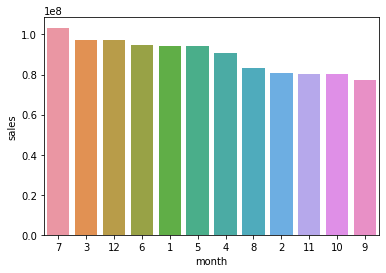

In [42]:
# Visualising total saales by months

sns.barplot(x= 'month', y= 'sales', data= sales_per_month, order= sales_per_month.sort_values(
    by= 'sales', ascending = False).month)

##### This result rejects our hypothesis that the gighest sales of the month occurs on December. It was presumed that December records the highest sales since many customers purchase items on the christmas season. But the data has proved otherwise.

## Q.4 Top 10 Stores based on total sales, and total transactions

To get the top 10 stores based on the total amount of sales they have made:
* We will group the store numbers by the total sales(sum) they have made and sort the values by sales
* After that we will plot a bar graph to visualise the Top 10 stores
* We will repeat same procedure using total transactions in place of total sales and observe the relationship between sales and transactions
* Plotting a Scatter graph to visualise the relationship between sales and transaction

In [43]:
# Grouping store numbers by total sales for each store number
highest_sales= train_data.groupby(['store_nbr'], as_index = False)['sales'].sum().sort_values(
    'sales', ascending=False).reset_index(drop=True)
highest_sales.head(10)

store_nbr         sales
0         44  6.208755e+07
1         45  5.449801e+07
2         47  5.094831e+07
3          3  5.048191e+07
4         49  4.342010e+07
5         46  4.189606e+07
6         48  3.593313e+07
7         51  3.291149e+07
8          8  3.049429e+07
9         50  2.865302e+07

<AxesSubplot:xlabel='store_nbr', ylabel='sales'>

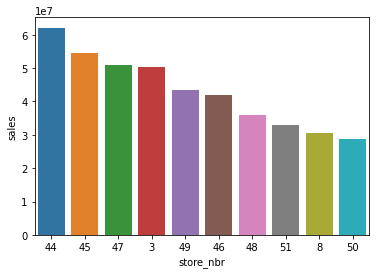

In [44]:
# Visualising top 10 stores according to total sales made

sns.barplot(x= 'store_nbr', y= 'sales', data= highest_sales.head(10),
    order= highest_sales.head(10).sort_values(by= 'sales', ascending = False).store_nbr)

In [45]:
# Grouping store numbers by total transactions made
highest_transactions= transactions.groupby(['store_nbr'], as_index = False)['transactions'].sum().sort_values(
    'transactions', ascending=False).reset_index(drop=True)
highest_transactions.head(10)

store_nbr  transactions
0         44       7273093
1         47       6535810
2         45       6201115
3         46       5990113
4          3       5366350
5         48       5107785
6          8       4637971
7         49       4574103
8         50       4384444
9         11       3972488

<AxesSubplot:xlabel='store_nbr', ylabel='transactions'>

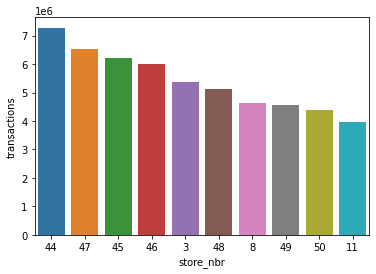

In [46]:
# Visualising top 10 stores according to total transaction made

sns.barplot(x= 'store_nbr', y= 'transactions', data= highest_transactions.head(10),
    order= highest_transactions.head(10).sort_values(by= 'transactions', ascending = False).store_nbr)

<AxesSubplot:title={'center':'Relationship btwn Total Sales and Transactions of stores'}, xlabel='sales', ylabel='transactions'>

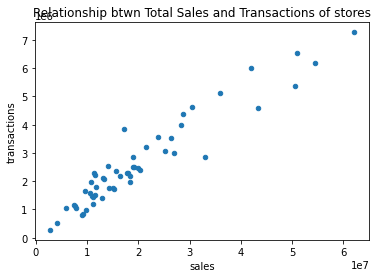

In [47]:
# Plotting a Scatter graph to visualise the relationship between sales and transaction
relation_sales_transaction = pd.merge(highest_transactions, highest_sales, on= 'store_nbr')
relation_sales_transaction.plot(x= 'sales', y= 'transactions', kind= 'scatter',
                          title= 'Relationship btwn Total Sales and Transactions of stores', colormap='GnBu_r')

## Q.5 What is the Sales Trend for each Family?

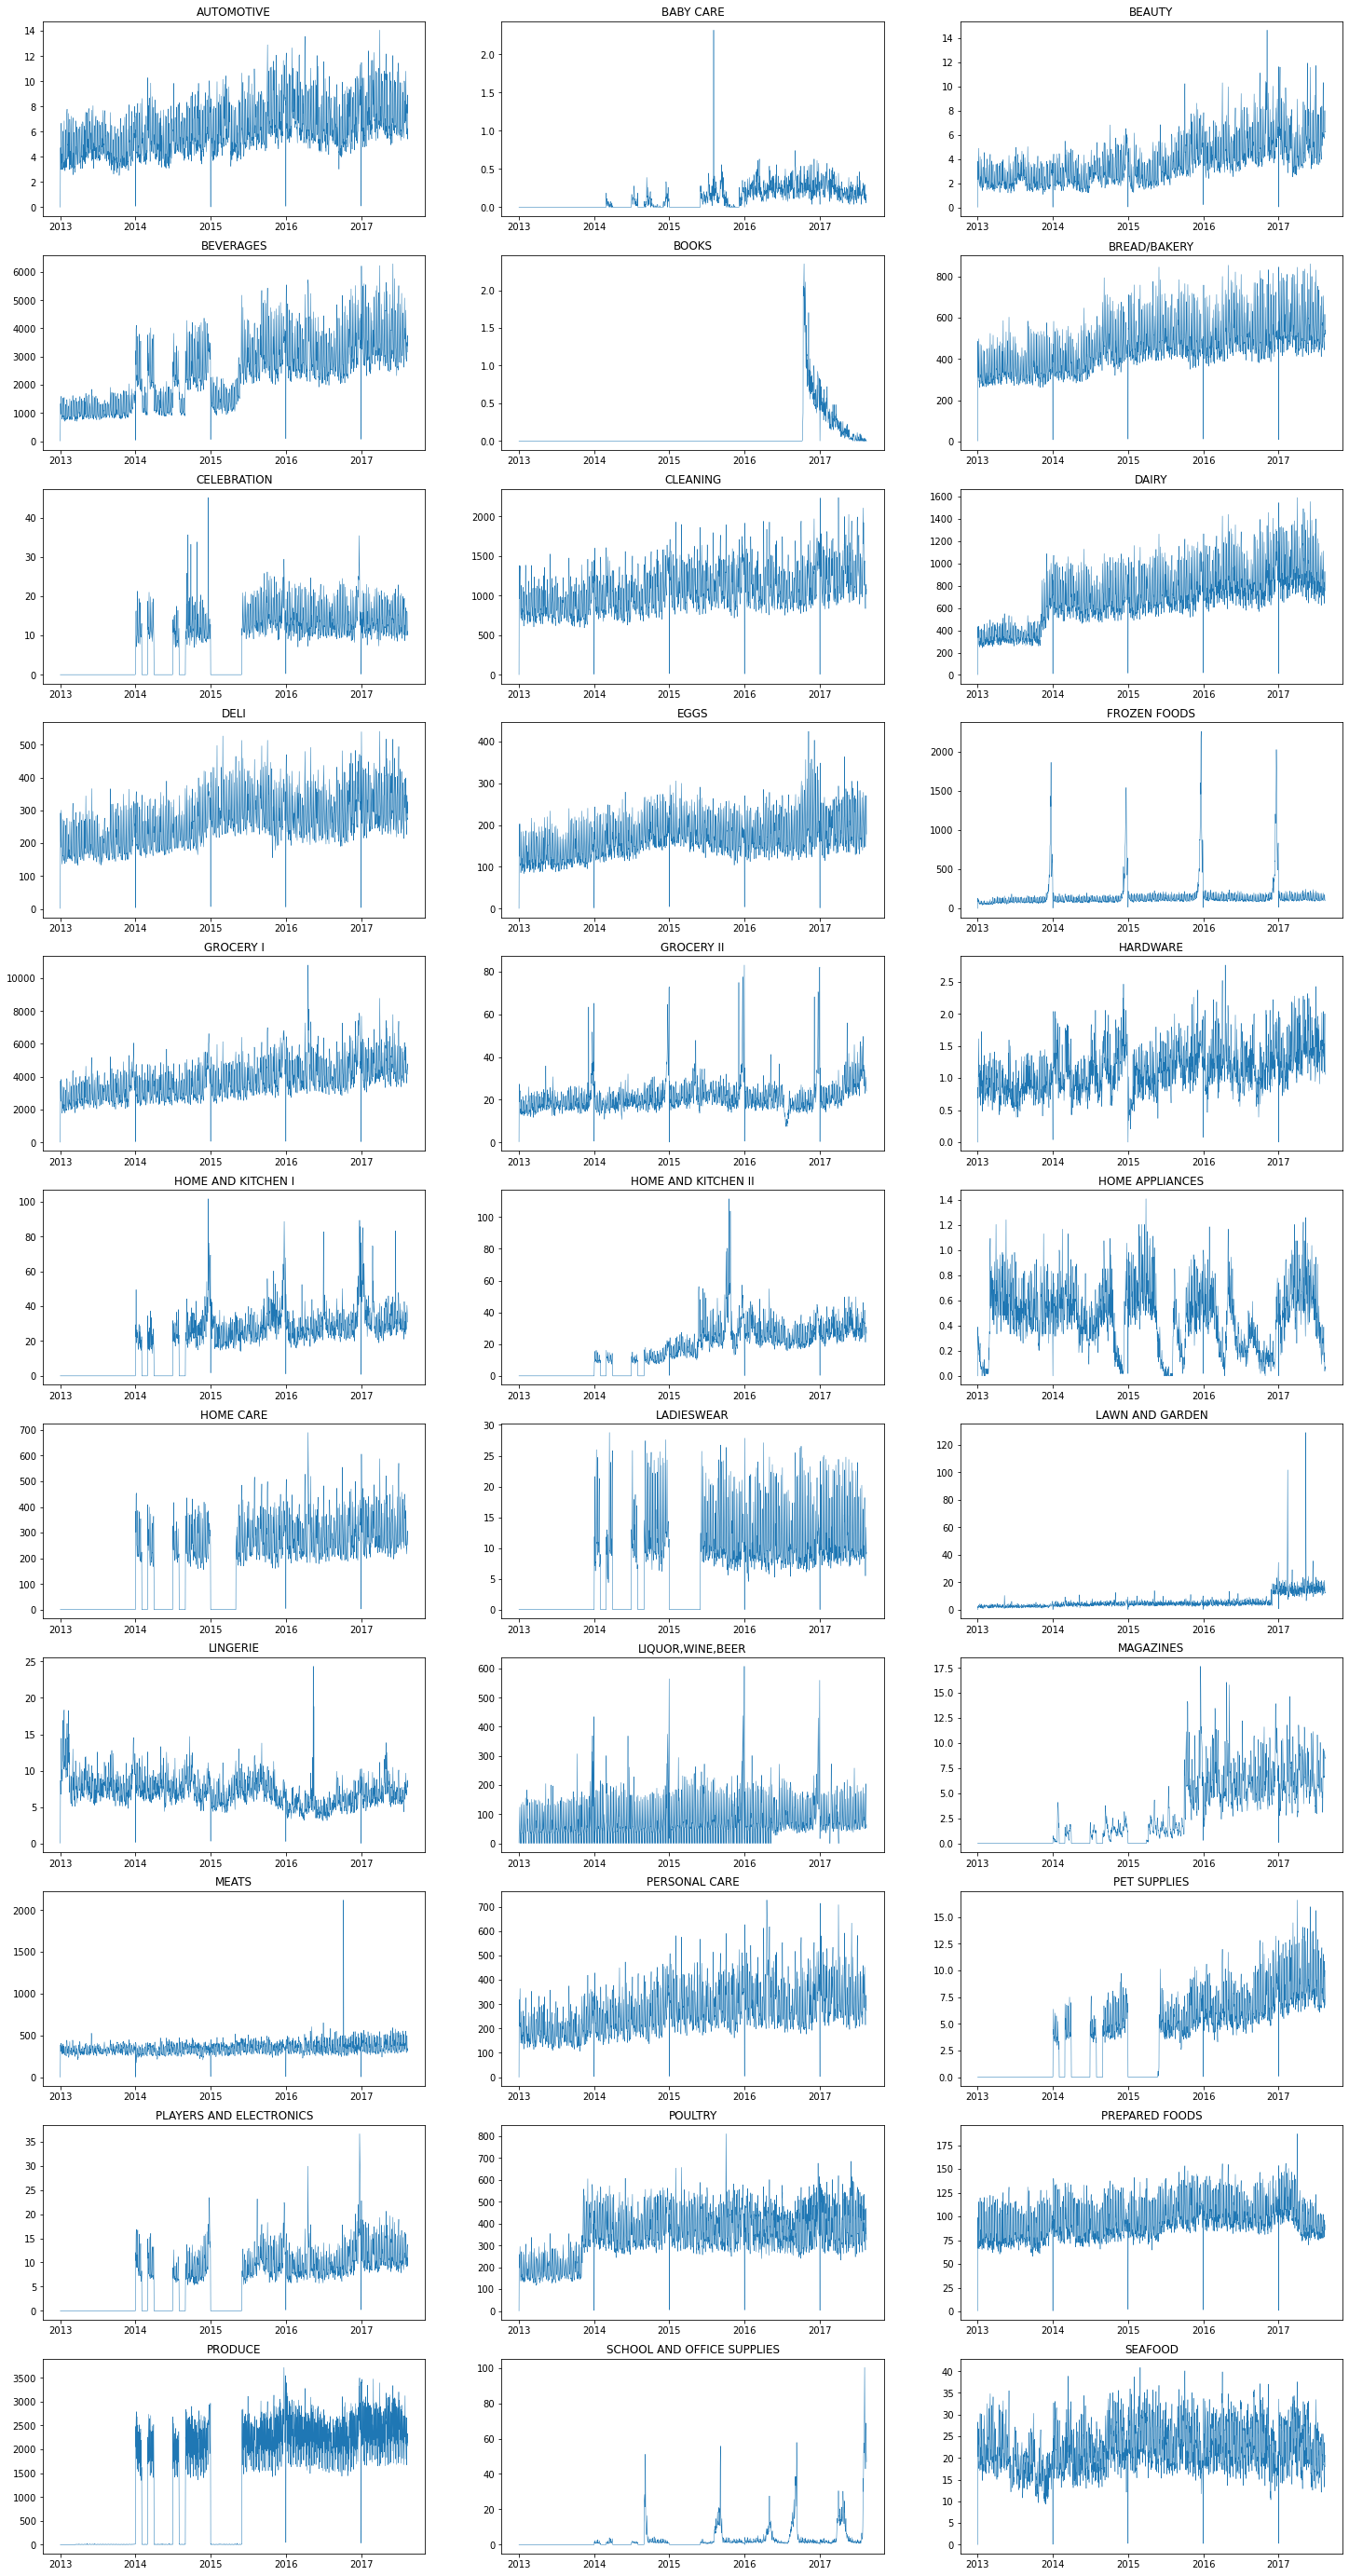

In [48]:
# Visualising mean sales for each family

"""Drawing families seperately will help us to know the unique features and trend for each product"""

FAMILIES =  train.family.unique() # combining all families in one list
fig,ax = plt.subplots(nrows = 11,ncols=3,figsize=(25,50))
for i,category in enumerate(FAMILIES):
    train_test = train.loc[(train['family']==category)].copy()
    train_test = train_test.groupby('date').mean()
    ax[i//3,i%3].plot(train_test.index,train_test.sales,linewidth=1/2)
    ax[i//3,i%3].set(title=category)

## Q.6 What is the Sales Trend for each Store Number?

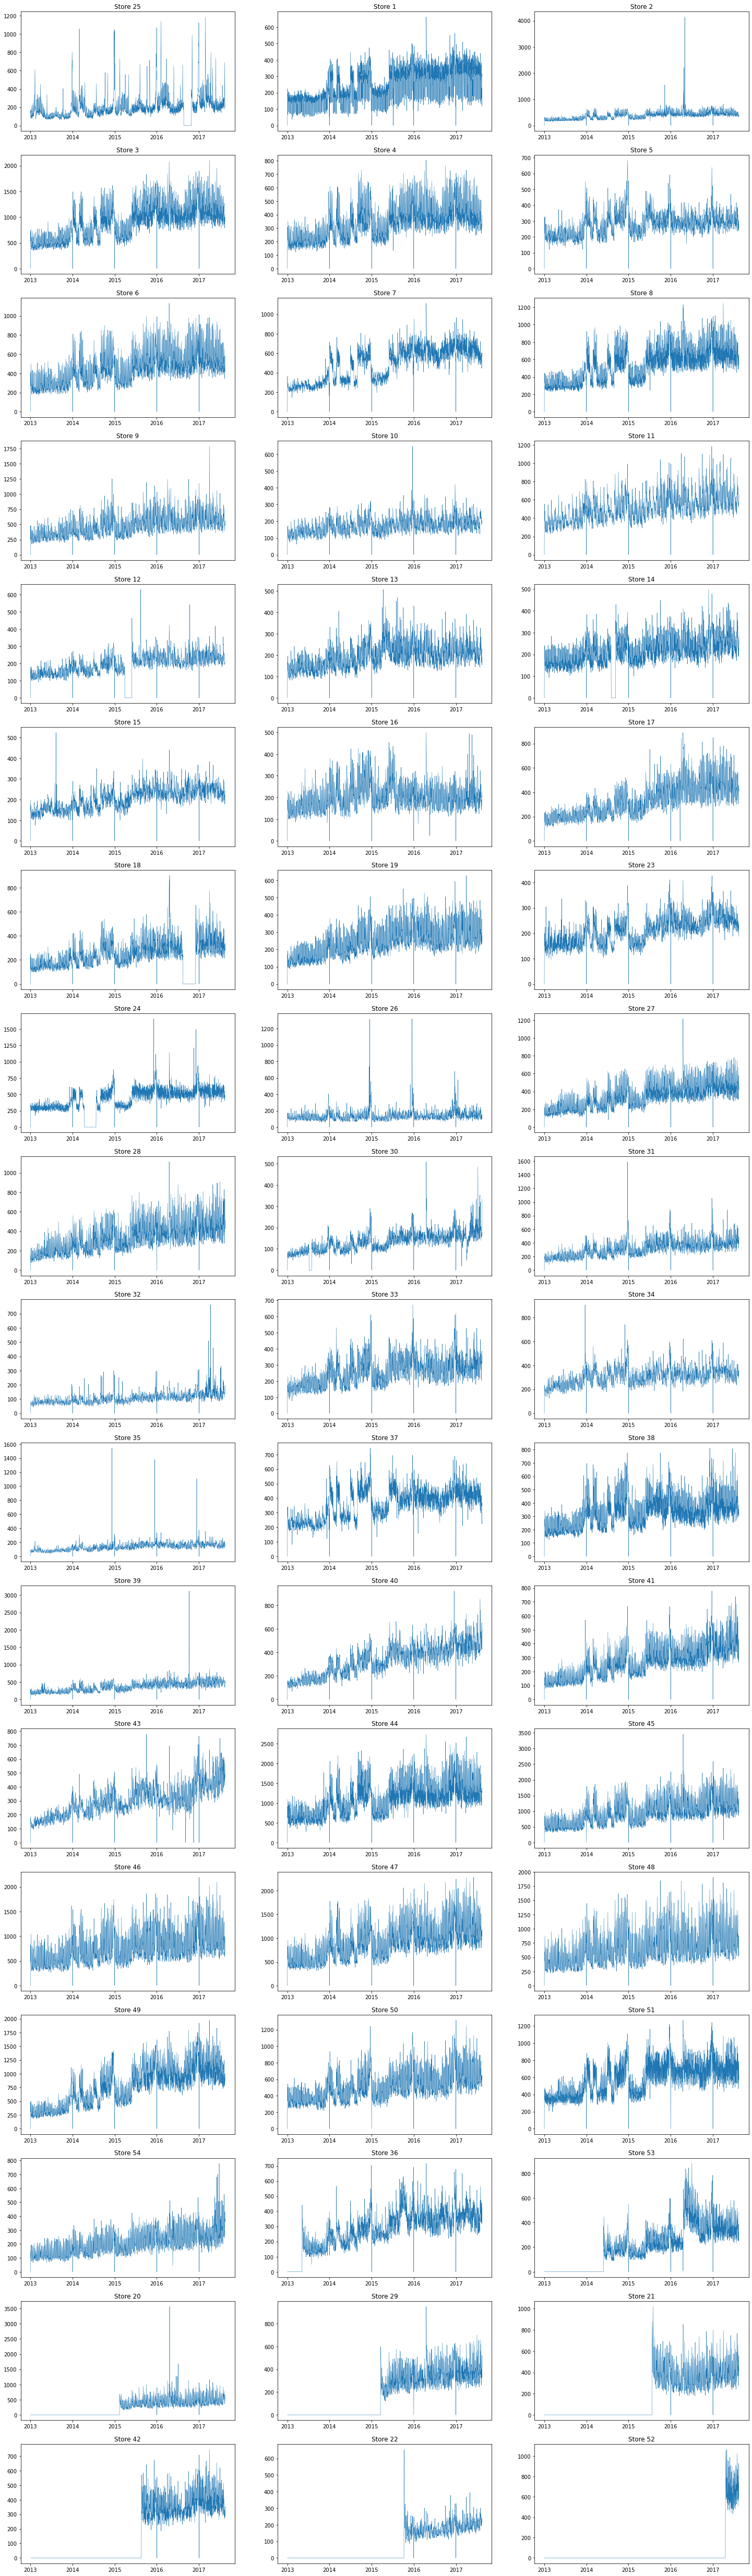

In [49]:
# Visualising mean sales for each store number

"""Drawing mean sales for each store number seperately will help us to know the unique features and sales trend for each store"""
STORES =  transactions.store_nbr.unique()
fig,ax = plt.subplots(nrows = 18,ncols=3,figsize=(25,90))
for i,category in enumerate(STORES):
    tmp = train.loc[(train['store_nbr']==category)].copy()
    tmp = tmp.groupby('date').mean()
    ax[i//3,i%3].plot(tmp.index, tmp.sales,linewidth=1/2)
    ax[i//3,i%3].set(title= 'Store '+ str(category))
    

## Q.7 What is the trend in transactions for each Store number?

In [50]:
# Converting date column in transaction data to datetime object
transactions['date'] = pd.to_datetime(transactions['date']).dt.date

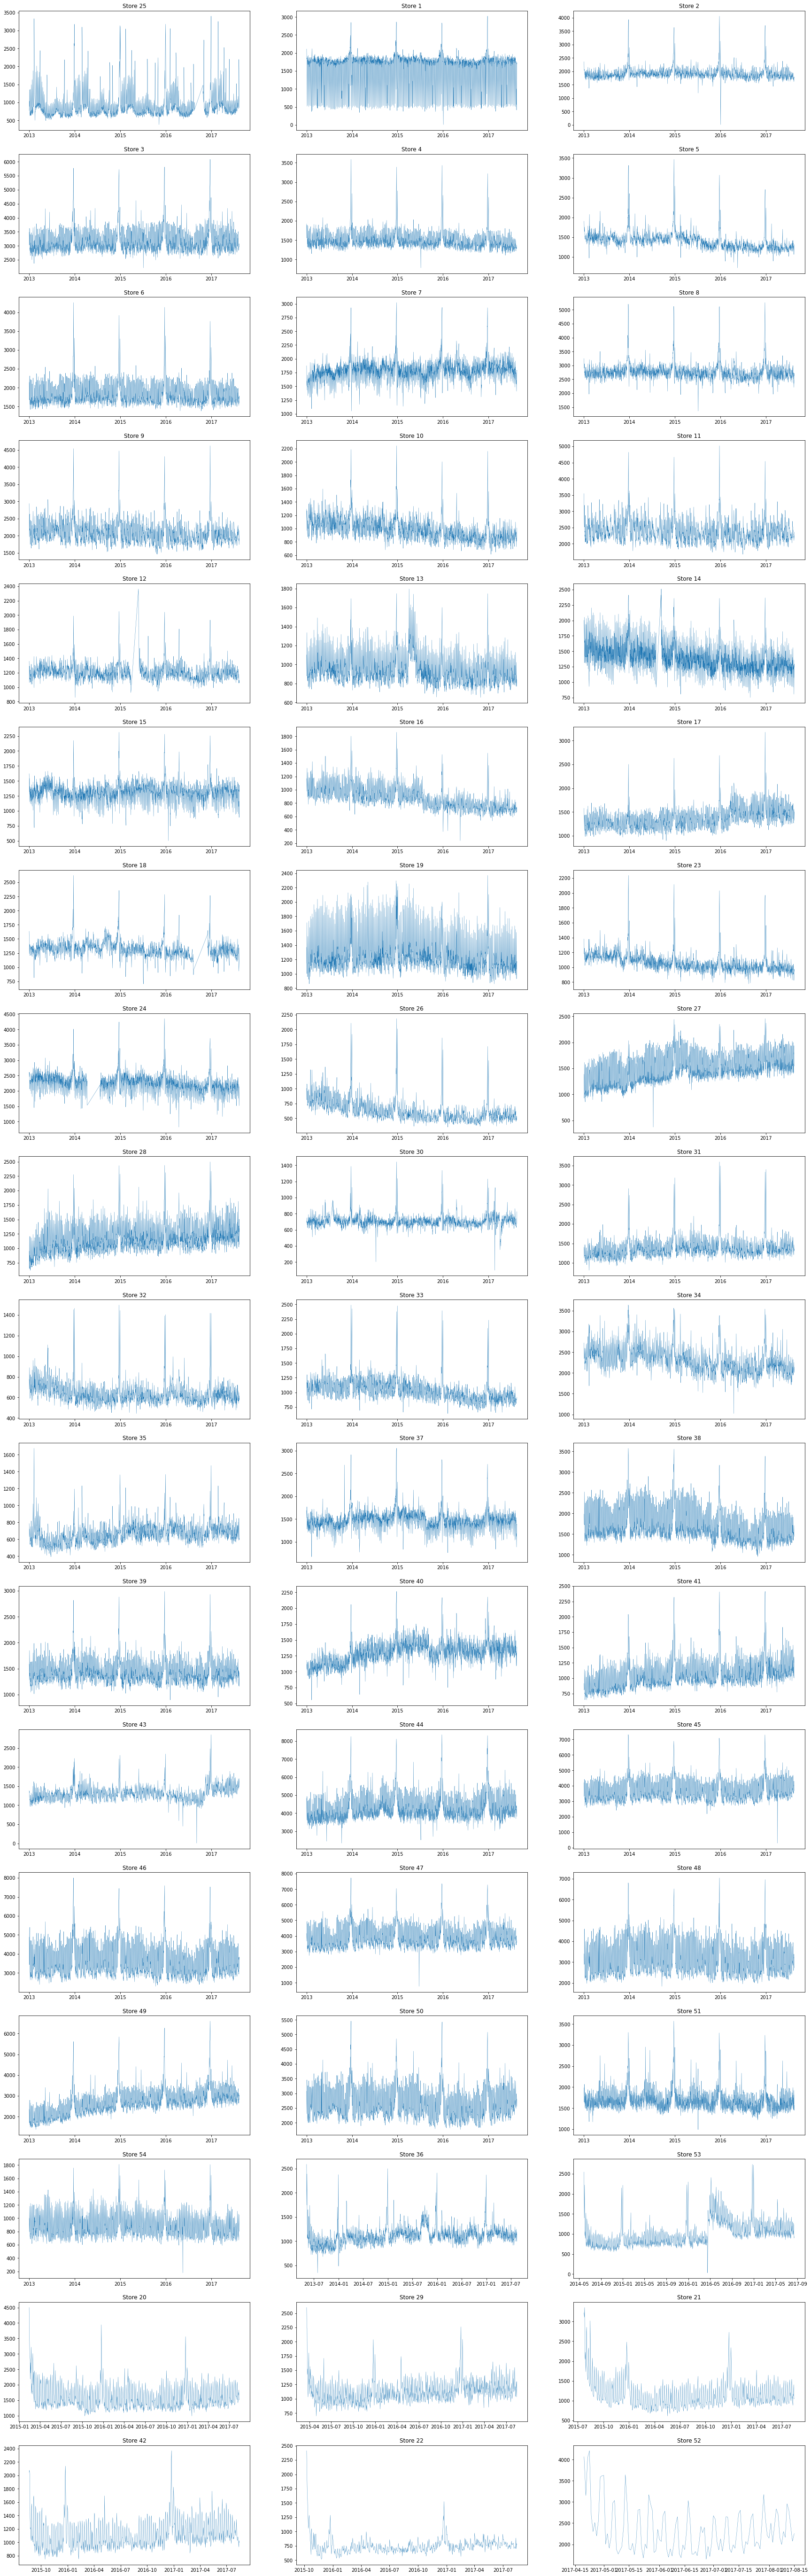

In [51]:
# Visualising mean transactions for each store number

"""Drawing mean transactions for each store seperately will help us to know the unique features and trend for each store number"""
STORES =  transactions.store_nbr.unique()
fig,ax = plt.subplots(nrows = 18,ncols=3,figsize=(30,100))
for i,category in enumerate(STORES):
    tmp = transactions.loc[(transactions['store_nbr']==category)].copy()
    tmp = tmp.groupby('date').mean()
    ax[i//3,i%3].plot(tmp.index,tmp.transactions,linewidth=0.4)
    ax[i//3,i%3].set(title= 'Store ' + str(category))

## Q.8 Are certain groups of stores selling more products? (Cluster, city, state, store_type)

To know whether certain group of stores are selling more products, we will:
* Merge store information data with train dataset for this analysis
* Group store '[cluster], [cities],[state], and [store_type]' by average sales using groupby method, and sort values in descending order to know which store group is making more sales
* Visualise these details on a separate barplots to observe the trends

In [52]:
# Merging store information data with train dataset for analysis
merged_stores= pd.merge(train_data, stores, on= 'store_nbr')
merged_stores.head()

date  store_nbr      family  sales  onpromotion  year  month   city  \
0  2013-01-01          1  AUTOMOTIVE    0.0          0.0  2013      1  Quito   
1  2013-01-01          1   BABY CARE    0.0          0.0  2013      1  Quito   
2  2013-01-01          1      BEAUTY    0.0          0.0  2013      1  Quito   
3  2013-01-01          1   BEVERAGES    0.0          0.0  2013      1  Quito   
4  2013-01-01          1       BOOKS    0.0          0.0  2013      1  Quito   

       state store_type  cluster  
0  Pichincha          D       13  
1  Pichincha          D       13  
2  Pichincha          D       13  
3  Pichincha          D       13  
4  Pichincha          D       13

In [53]:
#  Grouping store 'cluster' by total sales using groupby method and sort values in descending order

cluster= merged_stores.groupby(['cluster'], as_index = False
                              )['sales'].mean().sort_values(by='sales', ascending=False)
cluster

cluster        sales
4         5  1114.597753
13       14   706.549454
7         8   645.843786
10       11   602.076906
16       17   590.828119
5         6   341.849738
0         1   325.391067
11       12   323.692540
12       13   323.595472
3         4   295.870093
8         9   274.316755
1         2   259.554103
9        10   255.291153
15       16   238.032739
14       15   198.538523
2         3   193.955560
6         7   138.931858

In [54]:
#  Grouping store 'type' by total sales using groupby method and sort values in descending order

types = merged_stores.groupby(['store_type'], as_index = False
                              )['sales'].mean().sort_values(by='sales', ascending=False)
types

store_type       sales
0          A  704.206045
3          D  350.147702
1          B  325.965449
4          E  268.483573
2          C  196.795853

In [55]:
#  Grouping store 'state' by total sales using groupby method and sort values in descending order

state = merged_stores.groupby(['state'], as_index = False
                              )['sales'].sum().sort_values(by='sales', ascending=False)
state

state         sales
12                       Pichincha  5.850674e+08
6                           Guayas  1.651544e+08
0                            Azuay  4.916860e+07
15                      Tungurahua  4.030440e+07
14  Santo Domingo de los Tsachilas  3.583432e+07
4                           El Oro  3.338680e+07
9                         Los Rios  3.192537e+07
10                          Manabi  2.496982e+07
3                         Cotopaxi  2.118226e+07
8                             Loja  1.886000e+07
5                       Esmeraldas  1.639169e+07
1                          Bolivar  1.304951e+07
7                         Imbabura  1.145127e+07
13                     Santa Elena  1.142100e+07
2                       Chimborazo  1.138792e+07
11                         Pastaza  4.090202e+06

In [56]:
#  Grouping store 'city' by total sales using groupby method and sort values in descending order

city= merged_stores.groupby(['city'], as_index = False
                              )['sales'].sum().sort_values(by='sales', ascending=False)
city

city         sales
18          Quito  5.567418e+08
8       Guayaquil  1.229673e+08
3          Cuenca  4.916860e+07
0          Ambato  4.030440e+07
21  Santo Domingo  3.583432e+07
13        Machala  3.338680e+07
2         Cayambe  2.832556e+07
10      Latacunga  2.118226e+07
4           Daule  1.918802e+07
12           Loja  1.886000e+07
1        Babahoyo  1.774687e+07
6      Esmeraldas  1.639169e+07
11       Libertad  1.532243e+07
17        Quevedo  1.417850e+07
14          Manta  1.391234e+07
7        Guaranda  1.304951e+07
9          Ibarra  1.145127e+07
20        Salinas  1.142100e+07
19       Riobamba  1.138792e+07
5       El Carmen  1.105748e+07
15         Playas  7.676679e+06
16           Puyo  4.090202e+06

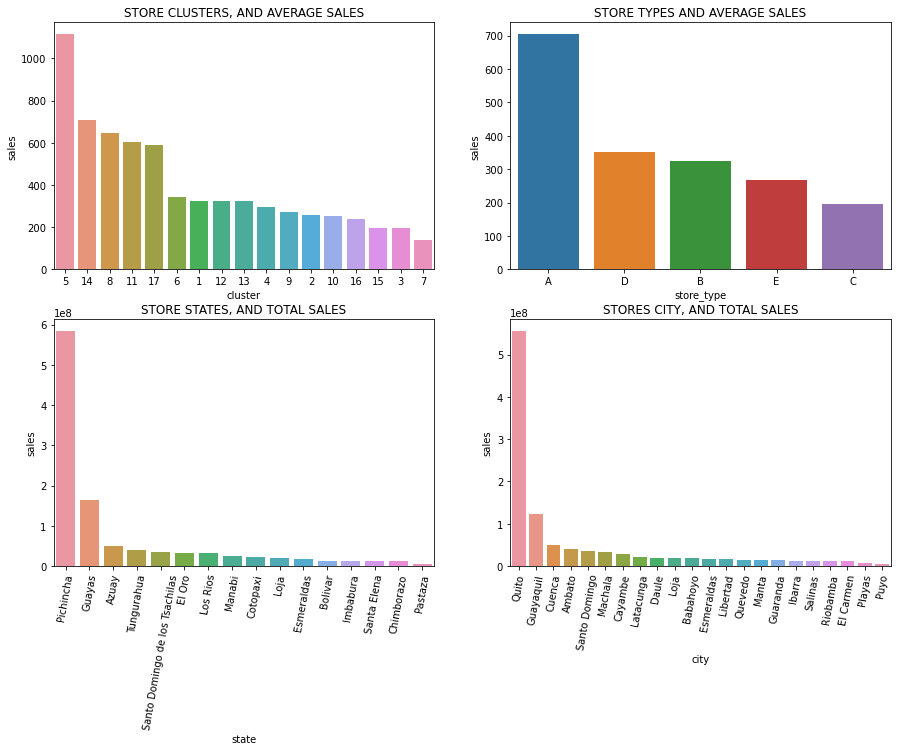

In [57]:
""" Plotting barplot to Visualise which group of stores are selling more prroducts"""

# Setting figure size, number of rows and columns for the plots
fig, axes = plt.subplots(nrows = 2,ncols=2,figsize=(15,10))

# Plotting graph for Clusters and Sales
sns.barplot(x= 'cluster', y= 'sales', data= cluster, ax=axes[0,0], 
        order= cluster.sort_values(by= 'sales', ascending = False).cluster)
# Plotting graph for Types and Sales
sns.barplot(x= 'store_type', y= 'sales', data= types, ax=axes[0,1],
    order= types.sort_values(by= 'sales', ascending = False).store_type)
# Plotting graph for State and Sales
sns.barplot(x= 'state', y= 'sales', data= state, ax=axes[1,0],
    order= state.sort_values(by= 'sales', ascending = False).state)
# Plotting graph for Cities and Sales
sns.barplot(x= 'city', y= 'sales', data= city, ax=axes[1,1],
    order= city.sort_values(by= 'sales', ascending = False).city)

# Setteing Titles for graphs
axes[0,0].set_title('STORE CLUSTERS, AND AVERAGE SALES')
axes[0,1].set_title('STORE TYPES AND AVERAGE SALES')
axes[1,0].set_title('STORE STATES, AND TOTAL SALES')
axes[1,1].set_title('STORES CITY, AND TOTAL SALES')

# Avoiding overlapping of xtick labels
axes[1,0].tick_params(axis='x', rotation=80)
axes[1,1].tick_params(axis='x', rotation=80)

##### Remarks

*  A total of 54 stores are available in 22 different Cities. Out of 54 stores, 18 are in Quito city and 8 in Guayaquil city. Most of Stores are in these two cities, while the remaining 28 stores are in the other cities.
* The Stores are distributed in a total of 16 states. Pichincha state alone has 19 stores, and Guayas State has 11 stores.The remaining are located in the other states


## Q.9 Did the earthquake that struck Ecuador on April 16, 2016 impact sales?

A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. It is speculated that this earthquake greatly affected sales for several weeks after the earthquake, as People rallied in relief efforts donating water and other first need products.
In order to evaluate whether the earthquake actually have an impact on sales, we will:
* Extract data for two weeks before the earthquake and calculate the total sales
* Extract data for two weeks after the earthquake and calculate the total sales
* Find the difference between the before_earthquake and after_earthquake sales to know how much impact the earthquake had on sales

In [58]:
# Extract data for two weeks before the earthquake ('2016-04-01' to '2016-04-15')

""" Using DataFrame.loc[] method to select DataFrame Rows """

train_data['date'] = pd.to_datetime(train_data['date'])
start_date = '2016-04-01'
end_date = '2016-04-15'

""" Select DataFrame rows between two dates""" 

mask = (train_data['date'] >= start_date) & (train_data['date'] <= end_date)
df1 = train_data.loc[mask]
df1


date  store_nbr                      family        sales  \
2108106 2016-04-01          1                  AUTOMOTIVE     8.000000   
2108107 2016-04-01          1                   BABY CARE     0.000000   
2108108 2016-04-01          1                      BEAUTY     2.000000   
2108109 2016-04-01          1                   BEVERAGES  2274.000000   
2108110 2016-04-01          1                       BOOKS     0.000000   
...            ...        ...                         ...          ...   
2134831 2016-04-15          9                     POULTRY   407.525000   
2134832 2016-04-15          9              PREPARED FOODS    63.760002   
2134833 2016-04-15          9                     PRODUCE   987.550000   
2134834 2016-04-15          9  SCHOOL AND OFFICE SUPPLIES     5.000000   
2134835 2016-04-15          9                     SEAFOOD    17.729000   

         onpromotion  year  month  
2108106          0.0  2016      4  
2108107          0.0  2016      4  
2108108          0.0  2016      4  
2108109          8.0  2016      4  
2108110          0.0  2016      4  
...              ...   ...    ...  
2134831         17.0  2016      4  
2134832          1.0  2016      4  
2134833          1.0  2016      4  
2134834          0.0  2016      4  
2134835          0.0  2016      4  

[26730 rows x 7 columns]

In [59]:
# Calculating total sales for two weeks period before the earthquake ('2016-04-01' to '2016-04-15')

print( 'Total sales for two weeks before earthquake is: ', df1.sales.sum())

Total sales for two weeks before earthquake is:  11974506.359719701


In [60]:
# Extract data for two weeks after the earthquake ('2016-04-17' to '2016-05-02')

""" Using pandas.DataFrame.query() to select DataFrame Rows """

start_date = '2016-04-17'
end_date   = '2016-05-02'
df2 = train_data.query('date >= @start_date and date <= @end_date')
df2

date  store_nbr                      family     sales  \
2136618 2016-04-17          1                  AUTOMOTIVE     1.000   
2136619 2016-04-17          1                   BABY CARE     0.000   
2136620 2016-04-17          1                      BEAUTY     3.000   
2136621 2016-04-17          1                   BEVERAGES  1717.000   
2136622 2016-04-17          1                       BOOKS     0.000   
...            ...        ...                         ...       ...   
2165125 2016-05-02          9                     POULTRY   547.221   
2165126 2016-05-02          9              PREPARED FOODS    79.324   
2165127 2016-05-02          9                     PRODUCE  1405.198   
2165128 2016-05-02          9  SCHOOL AND OFFICE SUPPLIES    10.000   
2165129 2016-05-02          9                     SEAFOOD    18.033   

         onpromotion  year  month  
2136618          0.0  2016      4  
2136619          0.0  2016      4  
2136620          0.0  2016      4  
2136621          3.0  2016      4  
2136622          0.0  2016      4  
...              ...   ...    ...  
2165125          1.0  2016      5  
2165126          0.0  2016      5  
2165127          1.0  2016      5  
2165128          0.0  2016      5  
2165129          0.0  2016      5  

[28512 rows x 7 columns]

In [61]:
# Calculating total sales for two weeks period after the earthquake ('2016-04-17' to '2016-05-02')

print( 'Total sales for two weeks after earthquake is: ', df2.sales.sum())

Total sales for two weeks after earthquake is:  15370504.1281985


In [62]:
# Calculating the difference between two_weeks_after_earthquake_sales and two_weeks_before_earthquake_sales

print( 'Difference: ', df2.sales.sum() - df1.sales.sum())

Difference:  3395997.7684787996


##### Now we can see that the total sales that the stores made within two weeks period after the earthquake is 3,395,997 more than total sales two weeks before the earthquake. So we can conclude that the earthquake positively impacted sales of items some weeks after the incidence

## Q.10 Are sales affected by promotions?

In [63]:

df3 = train_data.groupby(['onpromotion'], as_index = False
                              )['sales'].mean().sort_values(by='sales', ascending=True).reset_index(drop=True)
df3.head(10)

onpromotion        sales
0        279.0     0.000000
1          0.0   157.776039
2          1.0   467.556532
3          2.0   662.925632
4          3.0   871.408092
5          4.0   969.916135
6          5.0  1010.659835
7          7.0  1022.567058
8          6.0  1022.854287
9          8.0  1174.757003

<AxesSubplot:xlabel='onpromotion', ylabel='sales'>

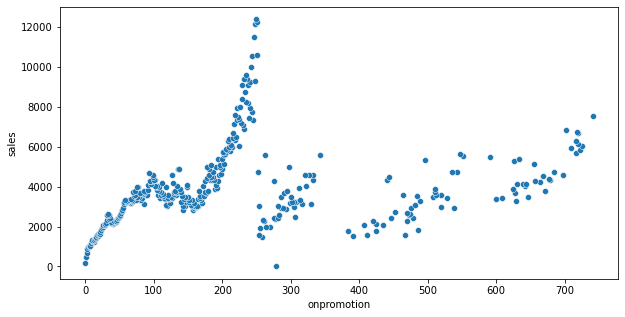

In [64]:
plt.figure(figsize=(10,5))
sns.scatterplot(x= 'onpromotion', y= 'sales', data= df3)

We can observe that sales tends to increase as promotion value increases. And Apart from sales value 279 which has an average sales of 0, the minimum average sales was recorded when promotion value was 0. Therefore we can accept the hypothesis that pro

# Feature Engineering

In [65]:
pd.set_option("display.max_columns", None) # Setting all columns to maximum display

In [66]:
# Merging store information data with train dataset
train_stores= pd.merge(train_data, stores, on= 'store_nbr')

In [67]:
holidays_event['date'] = pd.to_datetime(holidays_event['date'])
all_data = train_stores.merge(holidays_event, how='left', on=['date'])

In [68]:
# Calendar features
def getDateFeatures(df, date):
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.isocalendar().week
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df['is_weekend']= np.where(df['day_of_week'] > 4, 1, 0)
    df['is_month_start']= df.date.dt.is_month_start.astype(int)
    df['is_month_end']= df.date.dt.is_month_end.astype(int)
    df['quarter']= df.date.dt.quarter
    df['is_quarter_start']= df.date.dt.is_quarter_start.astype(int)
    df['is_quarter_end']= df.date.dt.is_quarter_end.astype(int)
    df['is_year_start']= df.date.dt.is_year_start.astype(int)
    
    return df

In [69]:
def dayType(row):
    # Denote work days and holidays for days that were not holidays
    if row.holiday_type is np.NaN: 
        if row.is_weekend == 0:
            return 'Workday'
        else:
            return 'No Work'
    # Denote special days
    elif row.holiday_type == 'Transfer' or row.holiday_type == 'Additional' or row.holiday_type == 'Bridge' or row.holiday_type == 'Event':
        return 'Special'
    # Rename work days
    elif row.holiday_type == 'Work Day':
        return 'Workday'
    # Add transferred holidays to special days
    elif row.transferred:
        return 'Special'
    else:
        return row.holiday_type

In [70]:
# Applying data to getDateFeatures Function
all_data= getDateFeatures(all_data, 'date')

In [71]:
# Applying data to day_type Function
all_data['day_type'] = all_data.apply(dayType, axis=1)

In [72]:
all_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3061476 entries, 0 to 3061475
Data columns (total 28 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   date              3061476 non-null  datetime64[ns]
 1   store_nbr         3061476 non-null  int64         
 2   family            3061476 non-null  object        
 3   sales             3061476 non-null  float64       
 4   onpromotion       3061476 non-null  float64       
 5   year              3061476 non-null  int64         
 6   month             3061476 non-null  int64         
 7   city              3061476 non-null  object        
 8   state             3061476 non-null  object        
 9   store_type        3061476 non-null  object        
 10  cluster           3061476 non-null  int64         
 11  holiday_type      509652 non-null   object        
 12  locale            509652 non-null   object        
 13  locale_name       509652 non-null   object

In [73]:
all_data.replace({'locale': {np.nan: 'None'},
                  'locale_name': {np.nan: 'None'},
                  'transferred': {np.nan: False}}, inplace=True)

In [74]:
cols = ['family', 'city', 'state', 'store_type', 'locale', 'locale_name', 'day_type', 'transferred']

for col in cols:
    all_data[col] = LabelEncoder().fit_transform(all_data[col])

<AxesSubplot:>

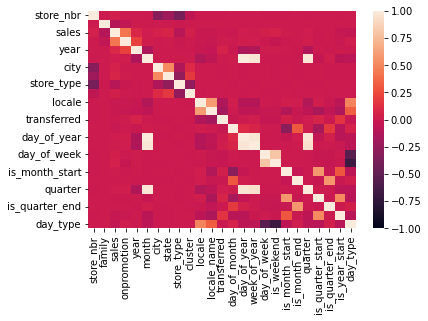

In [75]:
""" Checking for correlation between data columns"""
sns.heatmap(all_data.corr(), vmin= -1) # Plotting graph to visualise correlation

In [76]:
all_data

date  store_nbr  family  sales  onpromotion  year  month  city  \
0       2013-01-01          1       0    0.0          0.0  2013      1    18   
1       2013-01-01          1       1    0.0          0.0  2013      1    18   
2       2013-01-01          1       2    0.0          0.0  2013      1    18   
3       2013-01-01          1       3    0.0          0.0  2013      1    18   
4       2013-01-01          1       4    0.0          0.0  2013      1    18   
...            ...        ...     ...    ...          ...   ...    ...   ...   
3061471 2013-12-25          9      28    0.0          0.0  2013     12    18   
3061472 2013-12-25          9      29    0.0          0.0  2013     12    18   
3061473 2013-12-25          9      30    0.0          0.0  2013     12    18   
3061474 2013-12-25          9      31    0.0          0.0  2013     12    18   
3061475 2013-12-25          9      32    0.0          0.0  2013     12    18   

         state  store_type  cluster holiday_type  locale  locale_name  \
0           12           3       13      Holiday       1            4   
1           12           3       13      Holiday       1            4   
2           12           3       13      Holiday       1            4   
3           12           3       13      Holiday       1            4   
4           12           3       13      Holiday       1            4   
...        ...         ...      ...          ...     ...          ...   
3061471     12           1        6      Holiday       1            4   
3061472     12           1        6      Holiday       1            4   
3061473     12           1        6      Holiday       1            4   
3061474     12           1        6      Holiday       1            4   
3061475     12           1        6      Holiday       1            4   

                description  transferred  day_of_month  day_of_year  \
0        Primer dia del ano            0             1            1   
1        Primer dia del ano            0             1            1   
2        Primer dia del ano            0             1            1   
3        Primer dia del ano            0             1            1   
4        Primer dia del ano            0             1            1   
...                     ...          ...           ...          ...   
3061471             Navidad            0            25          359   
3061472             Navidad            0            25          359   
3061473             Navidad            0            25          359   
3061474             Navidad            0            25          359   
3061475             Navidad            0            25          359   

         week_of_year  day_of_week  is_weekend  is_month_start  is_month_end  \
0                   1            1           0               1             0   
1                   1            1           0               1             0   
2                   1            1           0               1             0   
3                   1            1           0               1             0   
4                   1            1           0               1             0   
...               ...          ...         ...             ...           ...   
3061471            52            2           0               0             0   
3061472            52            2           0               0             0   
3061473            52            2           0               0             0   
3061474            52            2           0               0             0   
3061475            52            2           0               0             0   

         quarter  is_quarter_start  is_quarter_end  is_year_start  day_type  
0              1                 1               0              1         0  
1              1                 1               0              1         0  
2              1                 1               0              1         0  
3              1                 1               0

In [77]:
drop_columns = ['sales', 'date', 'description', 'holiday_type']

In [78]:
X_train = all_data.drop(columns=drop_columns).values
y_train = all_data.sales.values

### Model Building

#### Baseline model
Since most of the sales are affected by a lot of categorical fields, various tree-based models can be applied to achieve optimal results. Thus, I'll use a <b>Decision Tree</b> as my baseline model. The model would also be used show the most relevant features.

#### Other models that can be used

* <b>Random Forest</b>
* <b>XGBoost</b>
* <b>Light GBM</b>

Since I'm using tree based algorithms feature scaling is not important since the data is divided and treated differently, thus I'm going to skip any feature scaling steps.

#### Decision Tree Regressor Model

In [79]:
# Defining decision_tree_model to train the data
decision_tree_model= DecisionTreeRegressor(random_state=167)

In [80]:
# Fitting/ Training model to our Train values
decision_tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=167)

<BarContainer object of 24 artists>

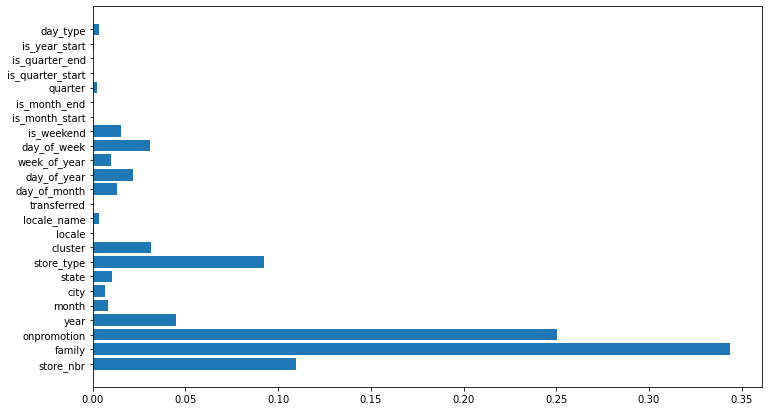

In [81]:
plt.figure(figsize=(12,7))
plt.barh(all_data.drop(columns=drop_columns).columns, decision_tree_model.feature_importances_)

##### According to the model, the most important features for the regression are onpromotion, family, store_nbr.

But these results are based on an evaluation with the RMSE.

Disadvantage of model choice:
* Can not specify RMSLE as evaluation metric.
​
To combat this and also get a sense of the model performance I'll use a backtest for cross validation.

### Model Validation

In [82]:
print(f'Min Date: {all_data.date.dt.date.min()}, Max Date: {all_data.date.dt.date.max()}')

Min Date: 2013-01-01, Max Date: 2017-08-15


#### Backtests To Test Model before submission

The backtest is simply a cross validation method that involves filtering out data from the training set and using the model to predict and score it to get an idea of the performance before picking the final model. 

The backtest here would be run on 3 periods with 15 days of data reserved for testing.

* Backtest 1 - Train with data from 2013-01-09 to 2017-06-30, Test on data from 2017-07-01 to 2017-07-15
* Backtest 2 - Train with data from 2013-01-09 to 2017-07-14, Test on data from 2017-07-15 to 2017-07-30
* Backtest 3 - Train with data from 2013-01-09 to 2017-07-31, Test on data from 2017-08-01 to 2017-08-15

In [83]:
backtests = {
    1: ('2017-07-01', '2017-07-15'),
    2: ('2017-07-15', '2017-07-30'),
    3: ('2017-08-01', '2017-08-15')
}

In [84]:
# Backtests with Decision Tree
scores = {}

for idx, period in enumerate(backtests):
    decision_tree = DecisionTreeRegressor()
    
    _train = all_data[all_data['date'] < backtests[period][0]]
    _test = all_data[(all_data['date'] >= backtests[period][0]) & (all_data['date'] <= backtests[period][1])]
    
    Xtrain, ytrain = _train.drop(columns=drop_columns).values, _train.sales.values
    Xtest, ytest = _test.drop(columns=drop_columns).values, _test.sales.values
    
    decision_tree_model = decision_tree.fit(Xtrain, ytrain)
    
    ypred = decision_tree_model.predict(Xtest)
    
    scores[period] = np.sqrt(msle(ytest, ypred))

In [85]:
print(scores)

{1: 0.5826202626564635, 2: 0.5826005980901958, 3: 0.587905959069978}


From the backtest the evaluation scores are not bad, but the evaluation method penalises more for underestimation than overestimation. This makes it safe to assume that the model probably had fewer incidents of underestimation and can be applied in it's raw state.

Further steps that can be taken to improve the model:

* Use a model that allows the use custom evaluation metric or even just RMSLE.
* Use backtest method to tune the hyperparameters for an optimal or consistent results.

#### Testing the model and producing final output

In [86]:
def prepareTestData(df):
    test_df = getDateFeatures(df, 'date')
    train_store = test_df.merge(stores, how='left', on=['store_nbr'])
    all_data = train_store.merge(holidays_event, how='left', on=['date'])
    all_data['day_type'] = all_data.apply(dayType, axis=1)
    all_data.replace({'locale': {np.nan: 'None'},
                  'locale_name': {np.nan: 'None'},
                  'transferred': {np.nan: False}}, inplace=True)
    cols = ['family', 'city', 'state', 'store_type', 'locale', 'locale_name', 'day_type', 'transferred']

    for col in cols:
        all_data[col] = LabelEncoder().fit_transform(all_data[col])
    
    return all_data

In [87]:
test_data = prepareTestData(test_df)

In [88]:
test_drop_columns = ['id', 'date', 'description', 'holiday_type']
y_test = test_data.drop(columns=test_drop_columns)
predictions = decision_tree_model.predict(y_test)

In [89]:
# Putting our test predicted values into a DataFrame valuable
sample_prediction =pd.DataFrame(predictions)
test= sample_submission.join(sample_prediction)
test_submission= test.drop(columns=['sales'])
test_submission.rename(columns={0:'saless'}, inplace=True)
test_submission

id    saless
0      3000888     5.000
1      3000889     0.000
2      3000890    12.000
3      3000891  2282.000
4      3000892     0.000
...        ...       ...
28507  3029395   252.521
28508  3029396   102.600
28509  3029397   502.790
28510  3029398  1154.358
28511  3029399     0.000

[28512 rows x 2 columns]

# Export

In [90]:
# Saving Requirements
requirements = '\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None))

with open('requirements.txt', 'w') as f:
    f.write(requirements)

In [91]:
# Objects tto export
to_export = {
    "encoder": None,
    "scaler": None,
    "model": decision_tree_model,
    "pipeline": None,
    "data1": train_data,
    "data2": stores,
    "data3": holidays_event,
    
    
}

In [92]:
# Exportation
with open('ML_items', 'wb') as file:
    pickle.dump(to_export, file)

In [93]:
# Loading after Exportation
with open('ML_items', 'rb') as file:
    loaded_object = pickle.load(file)

In [94]:
loaded_object

{'encoder': None,
 'scaler': None,
 'model': DecisionTreeRegressor(),
 'pipeline': None,
 'data1':               date  store_nbr                      family  sales  onpromotion  \
 0       2013-01-01          1                  AUTOMOTIVE    0.0          0.0   
 1       2013-01-01          1                   BABY CARE    0.0          0.0   
 2       2013-01-01          1                      BEAUTY    0.0          0.0   
 3       2013-01-01          1                   BEVERAGES    0.0          0.0   
 4       2013-01-01          1                       BOOKS    0.0          0.0   
 ...            ...        ...                         ...    ...          ...   
 3008011 2013-12-25          9                     POULTRY    0.0          0.0   
 3008012 2013-12-25          9              PREPARED FOODS    0.0          0.0   
 3008013 2013-12-25          9                     PRODUCE    0.0          0.0   
 3008014 2013-12-25          9  SCHOOL AND OFFICE SUPPLIES    0.0          0.0   
